In [1]:
import pandas as pd
import numpy as np
np.random.seed(0) 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

import glob
import os
import cv2
from tqdm import tqdm


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### import data

In [2]:
df= pd.read_csv("test/output/output0.csv")
df.head()

,Amplitudes,Frequencies,Daping coeffitients,Speeds,SNR
0,1.894824,229.127372,2.065563,3.139201,95.113244


In [3]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "test/output/output*.csv"))))

In [4]:
df

,Amplitudes,Frequencies,Daping coeffitients,Speeds,SNR
0,3.670712,213.277862,6.224857,-2.721940,14.291014
0,1.879941,163.226894,0.723691,7.404927,39.169301
0,3.948317,114.884776,6.203916,-2.328775,55.045094
0,2.680349,83.384335,1.240437,-5.460384,60.832520
0,2.375230,69.323893,5.489942,6.107269,61.373392
...,...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488,54.076477
0,4.804255,35.105291,9.873786,-3.589260,72.599596
0,4.715750,91.366737,6.698049,-2.129933,73.884334
0,4.778039,137.075316,4.295846,1.079967,27.511666


In [6]:
labels=df.iloc[:,:-1]
labels

,Amplitudes,Frequencies,Daping coeffitients,Speeds
0,3.670712,213.277862,6.224857,-2.721940
0,1.879941,163.226894,0.723691,7.404927
0,3.948317,114.884776,6.203916,-2.328775
0,2.680349,83.384335,1.240437,-5.460384
0,2.375230,69.323893,5.489942,6.107269
...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488
0,4.804255,35.105291,9.873786,-3.589260
0,4.715750,91.366737,6.698049,-2.129933
0,4.778039,137.075316,4.295846,1.079967


In [7]:
labels['image_name']=[f"input{x}" for x in range(0,len(labels))]
labels

,Amplitudes,Frequencies,Daping coeffitients,Speeds,image_name
0,3.670712,213.277862,6.224857,-2.721940,input0
0,1.879941,163.226894,0.723691,7.404927,input1
0,3.948317,114.884776,6.203916,-2.328775,input2
0,2.680349,83.384335,1.240437,-5.460384,input3
0,2.375230,69.323893,5.489942,6.107269,input4
...,...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488,input95
0,4.804255,35.105291,9.873786,-3.589260,input96
0,4.715750,91.366737,6.698049,-2.129933,input97
0,4.778039,137.075316,4.295846,1.079967,input98


In [8]:
labels.describe()

,Amplitudes,Frequencies,Daping coeffitients,Speeds
count,100.000000,100.000000,100.000000,100.000000
mean,2.491123,123.824120,4.891195,-0.320947
std,1.516537,68.432395,2.607755,4.776358
min,0.152405,17.777114,0.481182,-7.851334
25%,1.035943,62.571286,2.580401,-3.813275
50%,2.630638,120.850451,5.214697,-1.191793
75%,3.876328,183.038364,6.886415,3.592089
max,4.895953,236.906330,9.873786,7.976486


array([[<AxesSubplot:title={'center':'Amplitudes'}>,
        <AxesSubplot:title={'center':'Frequencies'}>],
       [<AxesSubplot:title={'center':'Daping coeffitients'}>,
        <AxesSubplot:title={'center':'Speeds'}>]], dtype=object)

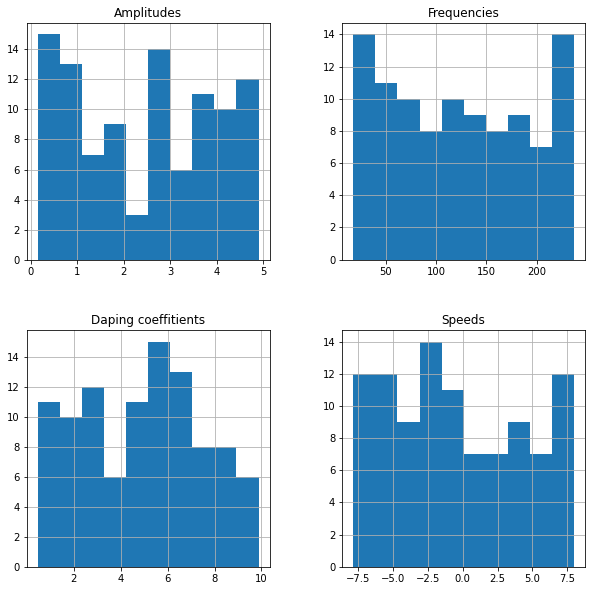

In [9]:
labels.hist(figsize=(10,10))

### Generate data

In [10]:
!git clone https://github.com/DahanDaniel/Algorithm_of_peak_picking.git

fatal: docelowa ścieżka „Algorithm_of_peak_picking” już istnieje i nie jest pustym katalogiem.


In [11]:
import sys
sys.path.insert(0, 'Algorithm_of_peak_picking')

In [12]:
%cd Algorithm_of_peak_picking/
!git pull
%cd ..

/home/anna_s/Ania/UW/projekty/NMR/predict_data/Algorithm_of_peak_picking
Już aktualne.
/home/anna_s/Ania/UW/projekty/NMR/predict_data


In [2]:
import copy
from sys import exit
import os

import numpy as np
# from google.colab import files

from Algorithm_of_peak_picking.RadonClass import *

In [153]:
ITERATIONS = 100

NO_SERIES  = 20
RESOLUTION = 2**8 # number of points describing spectra

DWMIN, DWMAX, DDW = -10, 10, .01 # Domain of rates of change

MAX_NO_PEAKS = 1

In [87]:
def create_random_data(max_no_peaks):
    # Draw a random number of peaks between 1 and max_no_peaks.
    N = np.random.randint(1, max_no_peaks+1)

    # Randomize peaks' parameters.
    amplitudes = np.random.uniform(.1, 5, N)
    frequencies = np.random.uniform(10, RESOLUTION - 10, N)
    damping_coeffs = np.random.uniform(0.1, 10, N)
    speeds = np.random.uniform(-8, 8, N)

    # Draw signal-to-noise ratio; set to 0 if no noise should be added.
    snr = np.random.uniform(10, 100) # 0 # 

    params = Params(amplitudes,
                    frequencies,
                    damping_coeffs,
                    speeds,
                    NO_SERIES,
                    RESOLUTION,
                    snr)
    
    radon_instance = Radon(params, DWMIN, DWMAX, DDW, 'Params')

    # Create input dataframe containing radon spectra of the input parameters.
    # Columns represent the frequency dimention,
    # rows represent the Radon (speeds) dimention.
    input_array = radon_instance.complex_Radon.real

    # Create output dataframe.
    output_df = pd.DataFrame({
        'Amplitudes': amplitudes,
        'Frequencies': frequencies,
        'Daping coeffitients': damping_coeffs,
        'Speeds': speeds
    })
    # output_df['SNR'] = snr # not included in fitting

    return input_array, output_df

In [16]:
# def download_data():
#     if not os.path.exists('data'):
#         os.makedirs('data')
#     for i in range(ITERATIONS):
#         input_df, output_df = create_random_data(MAX_NO_PEAKS)
#         input_df.to_csv('data/input%s.csv' % i, header=False, index=False)
#         output_df.to_csv('data/output%s.csv' % i, header=False, index=False)
#     files.download('data')

In [17]:
# def download_data():
#     if not os.path.exists('data'):
#         os.makedirs('data')
#     for i in range(ITERATIONS):
#         input_df, output_df = create_random_data(MAX_NO_PEAKS)
#         input_df.to_csv('data/input%s.csv' % i, header=False, index=False)
#         output_df.to_csv('data/output%s.csv' % i, header=False, index=False)
#     files.download('data')

In [18]:
# def generate_training_set():
#     X_train = []
#     y_train = []
#     for i in range(ITERATIONS):
#         input_array, output_df = create_random_data(MAX_NO_PEAKS)
#         X_train.append(input_array)
#         y_train.append(output_df)
#     df = pd.DataFrame({"x": X_train, "y": y_train})
#     return df

In [52]:
# def generate_training_set():
#     X_train = []
#     y_train = []
#     for i in range(ITERATIONS):
#         input_array, output_df = create_random_data(MAX_NO_PEAKS)
#         X_train.append(input_array)
#         y_train.append(output_df)
#     df_X = pd.DataFrame({"x": X_train})
#     df_y = pd.DataFrame({"y": y_train})
#     return df_X, df_y

In [154]:
def generate_dataset():
    X_ds = []
    df_y = pd.DataFrame()
    for i in range(ITERATIONS):
        input_array, output_df = create_random_data(MAX_NO_PEAKS)
        X_ds.append(input_array)
        df_y=df_y.append(pd.DataFrame(output_df))
    X_array = np.array(X_ds)
    return X_array, df_y

In [155]:
data_X, data_y = generate_dataset()

In [156]:
data_X

array([[[ 1.70892021e+01,  2.30345347e+01,  2.53727300e+01, ...,
          1.55906378e+01,  1.51746597e+01,  1.72605274e+01],
        [ 1.75492783e+01,  2.32406456e+01,  2.57757219e+01, ...,
          1.55431197e+01,  1.60328455e+01,  1.79278883e+01],
        [ 1.84394300e+01,  2.38684372e+01,  2.69420575e+01, ...,
          1.52030473e+01,  1.65432822e+01,  1.82179260e+01],
        ...,
        [ 1.18470960e+00,  1.82145923e+00,  1.54346077e+00, ...,
         -4.40356443e-02,  4.22806026e+00,  3.57028252e+00],
        [ 5.62373755e-01,  2.25560678e+00,  1.45263780e+00, ...,
         -1.60743163e-01,  2.67192001e+00,  3.06921825e+00],
        [-2.41728186e-01,  2.02227430e+00,  9.71938018e-01, ...,
          8.12694473e-01,  1.61824308e+00,  2.55279657e+00]],

       [[ 1.15721583e+01,  1.00022690e+01,  1.21931173e+01, ...,
          1.67618421e+01,  2.02293547e+01,  1.63164350e+01],
        [ 1.11526370e+01,  1.01352482e+01,  1.28754684e+01, ...,
          1.77554011e+01,  1.99863154e

### Preprocessing data

In [157]:
# normalization data
maxValue = np.amax(data_X)
maxValue

8894.807639045095

In [158]:
data_X /= maxValue

In [159]:
np.amax(data_X)

1.0

In [160]:
data_y

,Amplitudes,Frequencies,Daping coeffitients,Speeds
0,2.115239,223.548239,3.785228,2.044744
0,0.716958,149.544350,1.762577,-4.199938
0,1.187706,27.854517,4.031442,-0.998454
0,0.366942,85.135848,6.249120,-0.983750
0,3.033894,97.815050,6.187706,3.392649
...,...,...,...,...
0,4.133346,224.693724,1.335996,-3.787179
0,4.181185,109.696876,2.073955,-5.894142
0,4.317516,173.218206,8.389284,4.622735
0,3.863692,165.655274,8.932006,6.255857


In [161]:
data_y.shape

(100, 4)

In [ ]:
# reshape data
data_X.shape

In [21]:
K.image_data_format()

'channels_last'

In [22]:
img_rows, img_cols = 2000, 256

if K.image_data_format() == 'channels_last':
    data_X = data_X.reshape(data_X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    data_X = data_X.reshape(X_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
print(data_X.shape)

(100, 2000, 256, 1)


In [23]:
input_shape = data_X.shape
input_shape

(100, 2000, 256, 1)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3)

### Build the model CNN

In [163]:
def get_triple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4)
    ])

In [164]:
model = get_triple_cnn()
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])

model.summary()

ValueError: Input 0 of layer max_pooling2d_3 is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 100, 1998, 254, 32)

### Epochs and Batch Size

In [ ]:
epochs = 5  
batch_size = 20

### Fit the model

In [ ]:
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
  batch_size=batch_size, epochs=epochs,
  verbose=2,
  callbacks=[plot_losses],
  validation_data=(X_test, y_test))

### Evaluate model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])


In [ ]:
def draw_learning_curve(history, key='mae', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
draw_learning_curve(history, 'mae', ylim=(0.7, 1.))

In [ ]:
draw_learning_curve(history, 'loss', ylim=(0., 1.))

### Make predictions

In [ ]:
y_pred = model.predict(X_test)